In [1]:
import xarray as xr
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio import features
from affine import Affine
import geopandas as gpd
import rioxarray
import paths

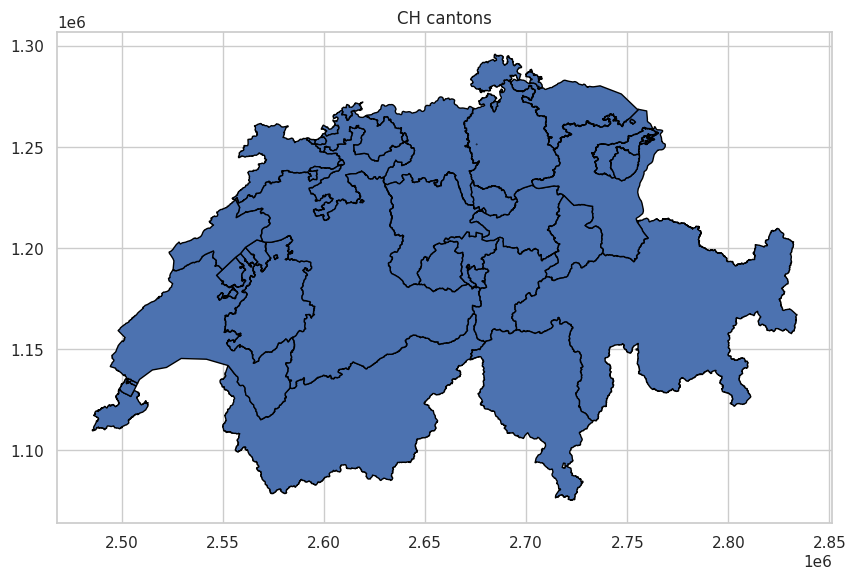

In [2]:
shp_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Processing_and_Analysis_Scripts/Cantons_zipfile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp"

gdf = gpd.read_file(shp_path)

gdf.plot(figsize=(10, 10), edgecolor='black')
plt.title("CH cantons")
plt.show()


Alpine	Graubünden	
Jura	Jura	
Central Plateau (Mittelland)	Bern	
Pre-Alpine / Foothills	Lucerne	
Southern / Mediterranean-influenced	Ticino

Some exploration. 


In [3]:
print(gdf.columns)

Index(['UUID', 'DATUM_AEND', 'DATUM_ERST', 'ERSTELL_J', 'ERSTELL_M',
       'GRUND_AEND', 'HERKUNFT', 'HERKUNFT_J', 'HERKUNFT_M', 'REVISION_J',
       'REVISION_M', 'REVISION_Q', 'OBJEKTART', 'KANTONSNUM', 'SEE_FLAECH',
       'KANTONSFLA', 'NAME', 'ICC', 'EINWOHNERZ', 'geometry'],
      dtype='object')


In [4]:
print(gdf["NAME"].unique())

['Genève' 'Thurgau' 'Valais' 'Aargau' 'Schwyz' 'Zürich' 'Obwalden'
 'Fribourg' 'Glarus' 'Uri' 'Nidwalden' 'Solothurn'
 'Appenzell Ausserrhoden' 'Jura' 'Graubünden' 'Vaud' 'Luzern' 'Ticino'
 'Zug' 'Basel-Landschaft' 'St. Gallen' 'Schaffhausen' 'Bern' 'Basel-Stadt'
 'Neuchâtel' 'Appenzell Innerrhoden']


In [5]:
shapefile= gpd.read_file("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Processing_and_Analysis_Scripts/Cantons_zipfile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp")
da = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Processing_and_Analysis_Scripts/data_1971_2023/HR_files_full/TabsD_1971_2023.nc")["TabsD"]

In [6]:
highlighted_cantons = {"Graubünden":"red", #Alpine
                       "Ticino":"blue", #mediterranean
                         "Luzern":"yellow",  #prealpin
                         "Aargau":"green", #mittelland
                         "Jura":"purple"} #plateau

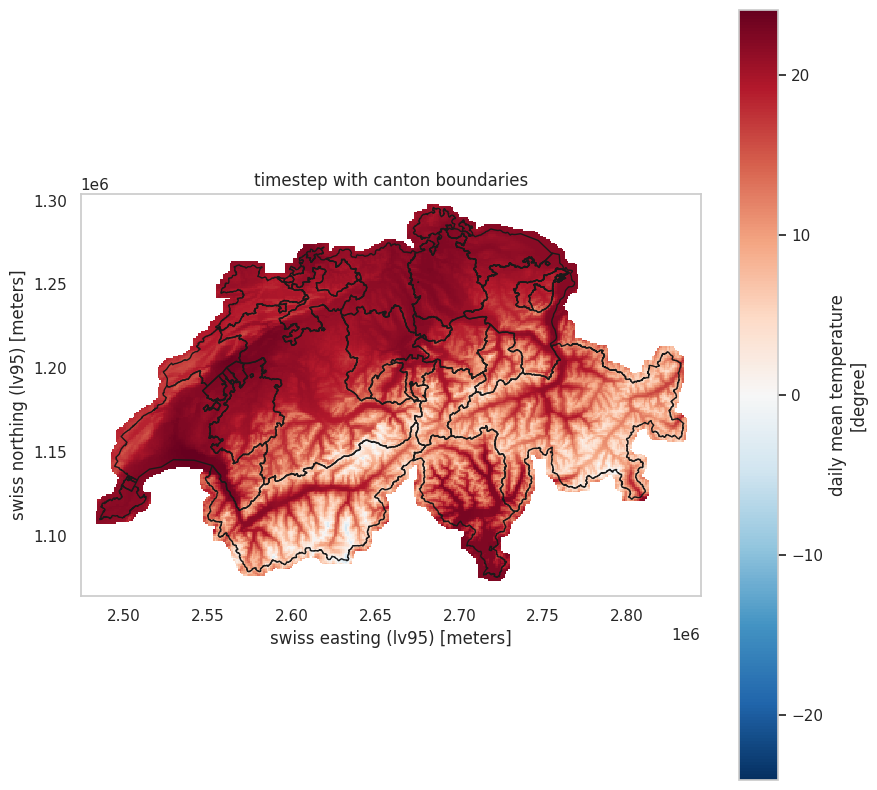

In [7]:
da_slice = da.isel(time=2000)

fig, ax = plt.subplots(figsize=(10, 10))
im = da_slice.plot(ax=ax)
shapefile.boundary.plot(ax=ax, color='k', linewidth=1)
plt.title("timestep with canton boundaries")
plt.show()

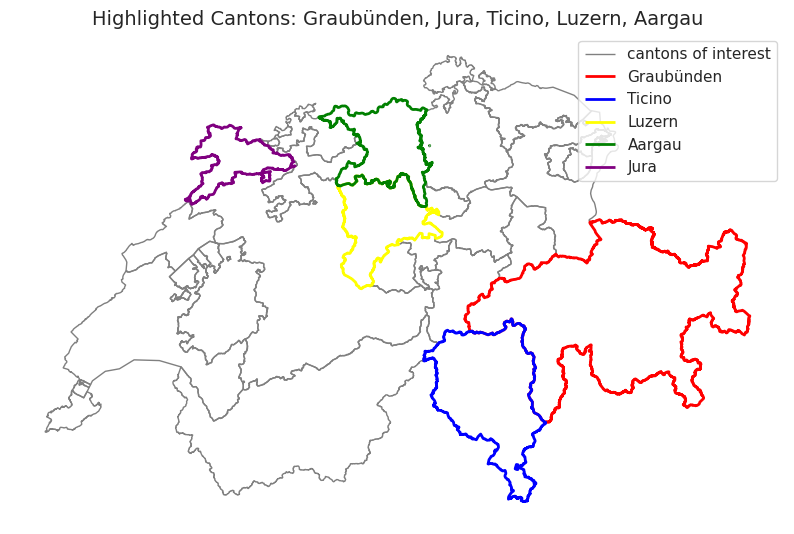

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, color='gray', linewidth=1, label='cantons of interest')

for canton,color in highlighted_cantons.items():
    gdf[gdf['NAME'] == canton].boundary.plot(ax=ax, color=color, linewidth=2, label=canton)

plt.title("Highlighted Cantons: Graubünden, Jura, Ticino, Luzern, Aargau", fontsize=14)
plt.legend()
plt.axis('off')
plt.show()

Cantonwise stats tbs as .nc files 

In [9]:
cantons= ["Graubünden"] #Alpine
time = da.time

canton_series = xr.DataArray(
    np.full((len(time), len(cantons)), np.nan),
    coords={"time": time, "canton": cantons},
    dims=["time", "canton"]
)

In [10]:
da_crs = da.rio.write_crs(gdf.crs)

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/pyproj/crs/_cf1x8.py:514: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


In [11]:
for i, canton in enumerate(cantons):
    shape = gdf[gdf["NAME"] == canton].geometry
    mask = da_crs.rio.clip(shape, gdf.crs, drop=False).notnull()

    #Mask creation
    masked = da_crs.where(mask)

    canton_series[:, i] = masked.mean(dim=("N", "E"), skipna=True)


canton_series.name = "TabsD_canton"
canton_series.to_netcdf(f"TabsD_canton_{canton}_timeseries.nc")

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/pyproj/crs/_cf1x8.py:514: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


In [12]:
#Obs
#Coarse files
# Bicubic files 
#Unet files
#LDM files

In [13]:
obs_precip=xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step1_latlon.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))
coarse_precip= xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step2_coarse.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))
bicubic_precip= xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step3_interp.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))
unet_precip=xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline_Huber.nc")["precip"].sel(time=slice("2011-01-01","2023-12-31"))

In [14]:
#ldm_precip=xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")["precip"].sel(time=slice("2011-01-01","2023-12-31"))

In [15]:
# After extracting the DataArray for each city/model:
def clean_and_slice(arr):
    # arr is an xarray.DataArray
    arr = arr.sel(time=slice("2011-01-01", "2023-12-31"))
    return arr.values[~np.isnan(arr.values)]

Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 270.14
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 260.57
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: -0.84 to 261.56
Variable 'precip' extracted
Time series shape: (4748,)
Data range: 0.85 to 178.27
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 74.20
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 77.33
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: -0.84 to 78.10
Variable 'precip' extracted
Time series shape: (4748,)
Data range: 0.85 to 45.46
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 95.92
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 90.68
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: -0.61 to 91.12
Variable 'precip' extracted
Time series shape: (4748,)
Data range: 0.85 to 53.85
Var

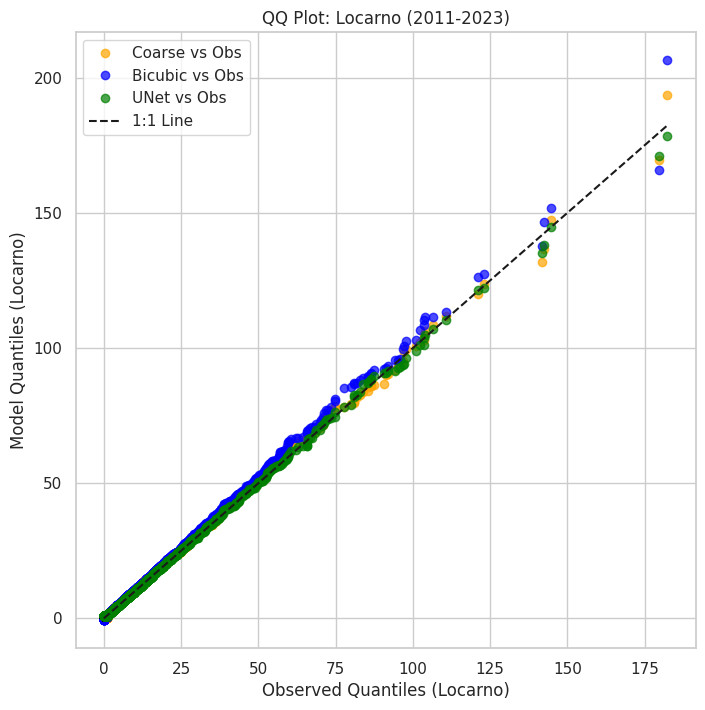

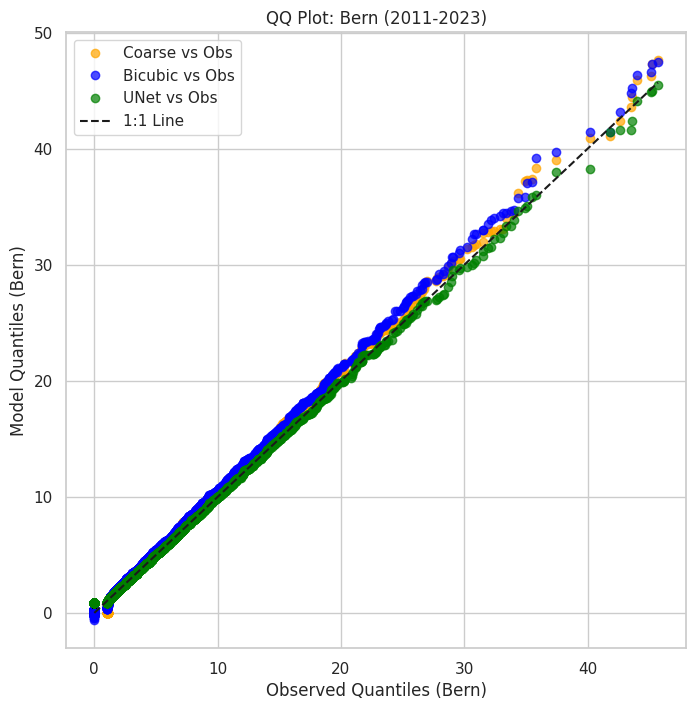

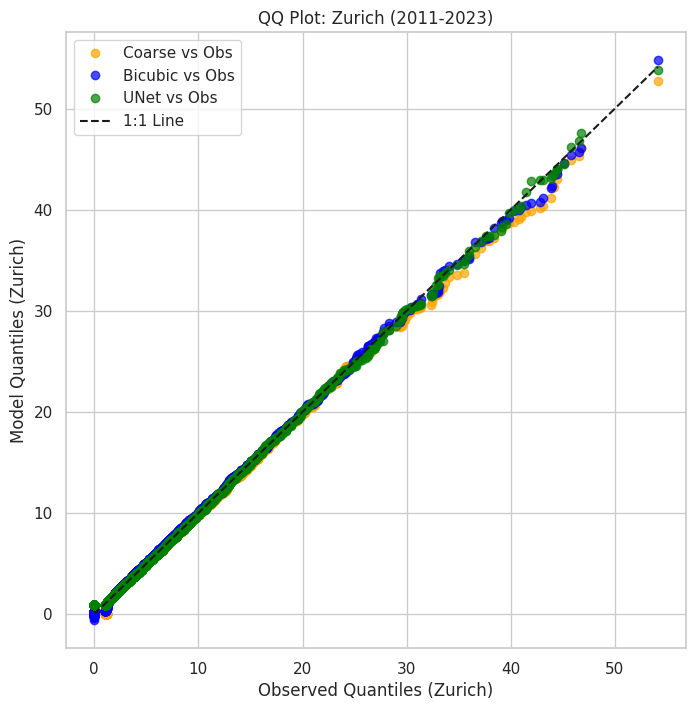

In [16]:
from closest_grid_cell import select_nearest_grid_cell

# City coordinates
locarno_lat, locarno_lon = 46.1709, 8.7995
bern_lat, bern_lon = 46.9480, 7.4474
zurich_lat, zurich_lon = 47.3769, 8.5417

# Open datasets as Dataset, not DataArray
obs_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step1_latlon.nc')
coarse_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step2_coarse.nc')
bicubic_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step3_interp.nc')
unet_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline_Huber.nc")
#ldm_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")

# Extract precip time series for Locarno
obs_locarno = select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
coarse_locarno = select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
bicubic_locarno = select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
unet_locarno = select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values
#ldm_locarno = select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values

# Extract time series for Bern
obs_bern = select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
coarse_bern = select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
bicubic_bern = select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
unet_bern = select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="precip")['data'].values
#ldm_bern = select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'].values



#Extract zurich 
obs_zurich = select_nearest_grid_cell(obs_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values
coarse_zurich = select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values
bicubic_zurich = select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values
unet_zurich = select_nearest_grid_cell(unet_ds, zurich_lat, zurich_lon, var_name="precip")['data'].values


# Locarno
obs_locarno = clean_and_slice(select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
coarse_locarno = clean_and_slice(select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
bicubic_locarno = clean_and_slice(select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
unet_locarno = clean_and_slice(select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="precip")['data'])
#ldm_locarno = clean_and_slice(select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'])

# Bern
obs_bern = clean_and_slice(select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
coarse_bern = clean_and_slice(select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
bicubic_bern = clean_and_slice(select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
unet_bern = clean_and_slice(select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="precip")['data'])
#ldm_bern = clean_and_slice(select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'])


#Zurich
obs_zurich = clean_and_slice(select_nearest_grid_cell(obs_ds, zurich_lat    , zurich_lon, var_name="RhiresD")['data'])
coarse_zurich = clean_and_slice(select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'])
bicubic_zurich = clean_and_slice(select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'])
unet_zurich = clean_and_slice(select_nearest_grid_cell(unet_ds, zurich_lat, zurich_lon, var_name="precip")['data'])

# Get common quantiles for Locarno
quantiles_locarno = np.linspace(0, 1, min(len(obs_locarno), len(coarse_locarno), len(bicubic_locarno)))
obs_q_locarno = np.quantile(obs_locarno, quantiles_locarno)
coarse_q_locarno = np.quantile(coarse_locarno, quantiles_locarno)
bicubic_q_locarno = np.quantile(bicubic_locarno, quantiles_locarno)
unet_q_locarno = np.quantile(unet_locarno, quantiles_locarno)
#ldm_q_locarno = np.quantile(ldm_locarno, quantiles_locarno)

# Get common quantiles for Bern
quantiles_bern = np.linspace(0, 1, min(len(obs_bern), len(coarse_bern), len(bicubic_bern)))
obs_q_bern = np.quantile(obs_bern, quantiles_bern)
coarse_q_bern = np.quantile(coarse_bern, quantiles_bern)
bicubic_q_bern = np.quantile(bicubic_bern, quantiles_bern)
unet_q_bern = np.quantile(unet_bern, quantiles_bern)
#ldm_q_bern = np.quantile(ldm_bern, quantiles_bern)


#Common quantiles for Zurich
quantiles_zurich = np.linspace(0, 1, min(len(obs_zurich), len(coarse_zurich), len(bicubic_zurich)))
obs_q_zurich = np.quantile(obs_zurich, quantiles_zurich)
coarse_q_zurich = np.quantile(coarse_zurich, quantiles_zurich)
bicubic_q_zurich = np.quantile(bicubic_zurich, quantiles_zurich)
unet_q_zurich = np.quantile(unet_zurich, quantiles_zurich)

# Plot QQ for Locarno
plt.figure(figsize=(8, 8))
plt.plot(obs_q_locarno, coarse_q_locarno, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_locarno, bicubic_q_locarno, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
plt.plot(obs_q_locarno, unet_q_locarno, 'o', label='UNet vs Obs',color='green', alpha=0.7)
#plt.plot(obs_q_locarno, ldm_q_locarno, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_locarno.min(), obs_q_locarno.max()], [obs_q_locarno.min(), obs_q_locarno.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Locarno)')
plt.ylabel('Model Quantiles (Locarno)')
plt.title('QQ Plot: Locarno (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

# Plot QQ for Bern
plt.figure(figsize=(8, 8))
plt.plot(obs_q_bern, coarse_q_bern, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_bern, bicubic_q_bern, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
plt.plot(obs_q_bern, unet_q_bern, 'o', label='UNet vs Obs',color='green', alpha=0.7)
#plt.plot(obs_q_bern, ldm_q_bern, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_bern.min(), obs_q_bern.max()], [obs_q_bern.min(), obs_q_bern.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Bern)')
plt.ylabel('Model Quantiles (Bern)')
plt.title('QQ Plot: Bern (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()



# Plot QQ for Zurich
plt.figure(figsize=(8, 8))
plt.plot(obs_q_zurich, coarse_q_zurich, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_zurich, bicubic_q_zurich, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
plt.plot(obs_q_zurich, unet_q_zurich, 'o', label='UNet vs Obs',color='green', alpha=0.7)
plt.plot([obs_q_zurich.min(), obs_q_zurich.max()], [obs_q_zurich.min(), obs_q_zurich.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Zurich)')
plt.ylabel('Model Quantiles (Zurich)')
plt.title('QQ Plot: Zurich (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

Temperature QQ plot

In [17]:
obs_temp=xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step1_latlon.nc')["TabsD"].sel(time=slice("2011-01-01","2023-12-31"))
coarse_temp= xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step2_coarse.nc')["TabsD"].sel(time=slice("2011-01-01","2023-12-31"))
bicubic_temp= xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step3_interp.nc')["TabsD"].sel(time=slice("2011-01-01","2023-12-31"))
unet_temp=xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline_Huber.nc")["temp"].sel(time=slice("2011-01-01","2023-12-31"))

Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -7.54 to 30.31
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -13.87 to 26.11
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -13.54 to 26.32
Variable 'temp' extracted
Time series shape: (4748,)
Data range: -6.67 to 29.66
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -17.65 to 27.63
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -17.97 to 27.46
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -18.21 to 27.37
Variable 'temp' extracted
Time series shape: (4748,)
Data range: -14.40 to 27.58
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -17.89 to 28.21
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -18.90 to 27.82
Variable 'TabsD' extracted
Time series shape: (19358,)
Data range: -18.81 to 27.79
Variable 'temp' extracted
Time series shape: (4748,)
Data range: -12.43 to 28.16
Variable 'Ta

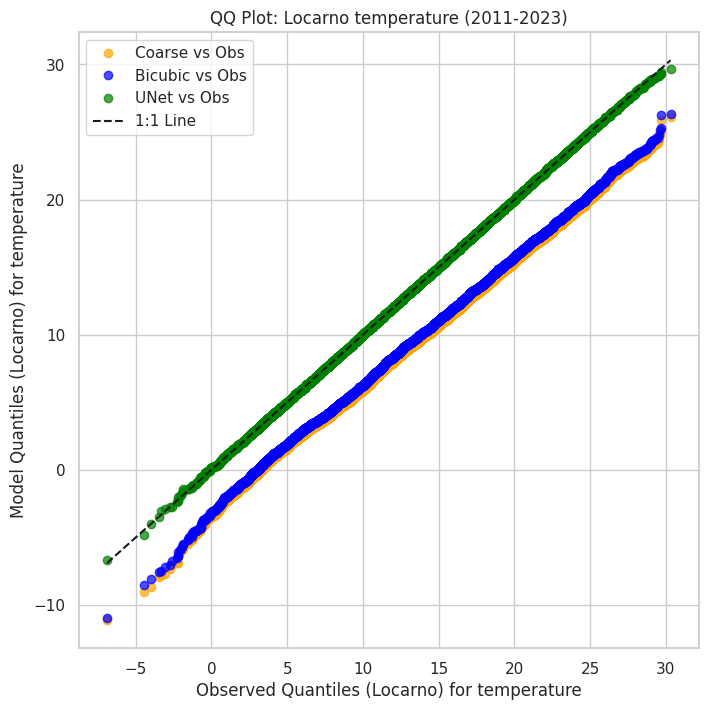

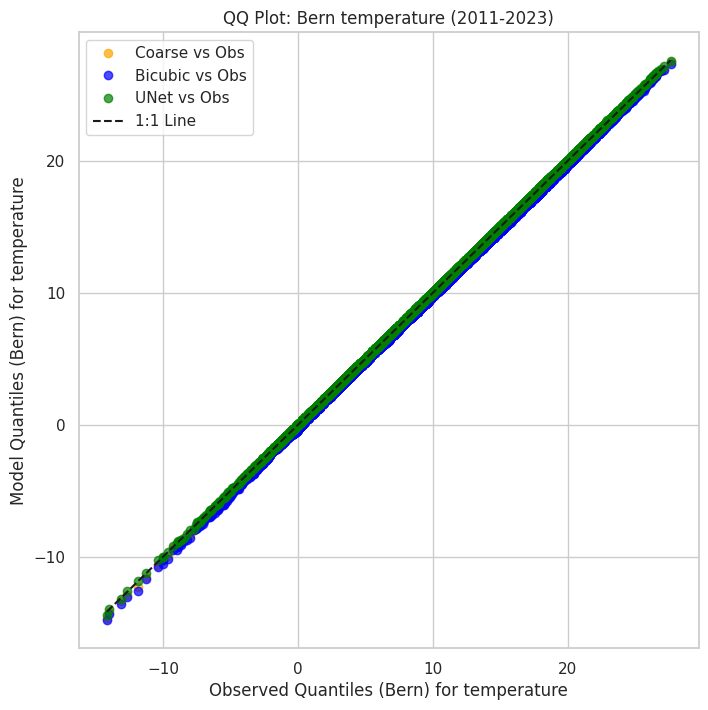

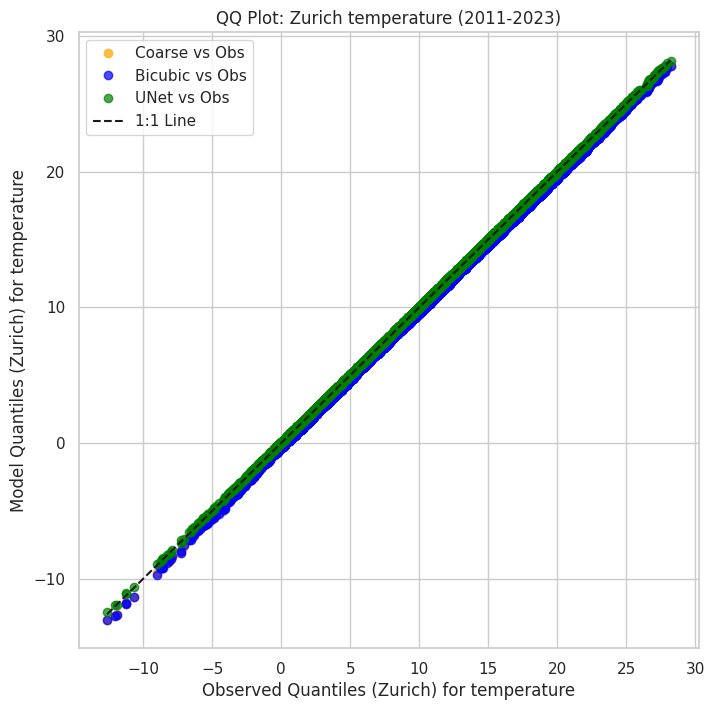

In [18]:
from closest_grid_cell import select_nearest_grid_cell

# City coordinates
locarno_lat, locarno_lon = 46.1709, 8.7995
bern_lat, bern_lon = 46.9480, 7.4474
zurich_lat, zurich_lon = 47.3769, 8.5417

# Open datasets as Dataset, not DataArray
obs_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step1_latlon.nc')
coarse_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step2_coarse.nc')
bicubic_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/TabsD_step3_interp.nc')
unet_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline_Huber.nc")
#ldm_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")

# Extract precip time series for Locarno
obs_locarno = select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
coarse_locarno = select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
bicubic_locarno = select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'].values
unet_locarno = select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="temp")['data'].values
#ldm_locarno = select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values

# Extract time series for Bern
obs_bern = select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="TabsD")['data'].values
coarse_bern = select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="TabsD")['data'].values
bicubic_bern = select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="TabsD")['data'].values
unet_bern = select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="temp")['data'].values
#ldm_bern = select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'].values



#Extract zurich 
obs_zurich = select_nearest_grid_cell(obs_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'].values
coarse_zurich = select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'].values
bicubic_zurich = select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'].values
unet_zurich = select_nearest_grid_cell(unet_ds, zurich_lat, zurich_lon, var_name="temp")['data'].values


# Locarno
obs_locarno = clean_and_slice(select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'])
coarse_locarno = clean_and_slice(select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'])
bicubic_locarno = clean_and_slice(select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="TabsD")['data'])
unet_locarno = clean_and_slice(select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="temp")['data'])
#ldm_locarno = clean_and_slice(select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'])

# Bern
obs_bern = clean_and_slice(select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="TabsD")['data'])
coarse_bern = clean_and_slice(select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="TabsD")['data'])
bicubic_bern = clean_and_slice(select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="TabsD")['data'])
unet_bern = clean_and_slice(select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="temp")['data'])
#ldm_bern = clean_and_slice(select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'])


#Zurich
obs_zurich = clean_and_slice(select_nearest_grid_cell(obs_ds, zurich_lat    , zurich_lon, var_name="TabsD")['data'])
coarse_zurich = clean_and_slice(select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'])
bicubic_zurich = clean_and_slice(select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="TabsD")['data'])
unet_zurich = clean_and_slice(select_nearest_grid_cell(unet_ds, zurich_lat, zurich_lon, var_name="temp")['data'])

# Get common quantiles for Locarno
quantiles_locarno = np.linspace(0, 1, min(len(obs_locarno), len(coarse_locarno), len(bicubic_locarno)))
obs_q_locarno = np.quantile(obs_locarno, quantiles_locarno)
coarse_q_locarno = np.quantile(coarse_locarno, quantiles_locarno)
bicubic_q_locarno = np.quantile(bicubic_locarno, quantiles_locarno)
unet_q_locarno = np.quantile(unet_locarno, quantiles_locarno)
#ldm_q_locarno = np.quantile(ldm_locarno, quantiles_locarno)

# Get common quantiles for Bern
quantiles_bern = np.linspace(0, 1, min(len(obs_bern), len(coarse_bern), len(bicubic_bern)))
obs_q_bern = np.quantile(obs_bern, quantiles_bern)
coarse_q_bern = np.quantile(coarse_bern, quantiles_bern)
bicubic_q_bern = np.quantile(bicubic_bern, quantiles_bern)
unet_q_bern = np.quantile(unet_bern, quantiles_bern)
#ldm_q_bern = np.quantile(ldm_bern, quantiles_bern)


#Common quantiles for Zurich
quantiles_zurich = np.linspace(0, 1, min(len(obs_zurich), len(coarse_zurich), len(bicubic_zurich)))
obs_q_zurich = np.quantile(obs_zurich, quantiles_zurich)
coarse_q_zurich = np.quantile(coarse_zurich, quantiles_zurich)
bicubic_q_zurich = np.quantile(bicubic_zurich, quantiles_zurich)
unet_q_zurich = np.quantile(unet_zurich, quantiles_zurich)

# Plot QQ for Locarno
plt.figure(figsize=(8, 8))
plt.plot(obs_q_locarno, coarse_q_locarno, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_locarno, bicubic_q_locarno, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
plt.plot(obs_q_locarno, unet_q_locarno, 'o', label='UNet vs Obs',color='green', alpha=0.7)
#plt.plot(obs_q_locarno, ldm_q_locarno, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_locarno.min(), obs_q_locarno.max()], [obs_q_locarno.min(), obs_q_locarno.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Locarno) for temperature')
plt.ylabel('Model Quantiles (Locarno) for temperature')
plt.title('QQ Plot: Locarno temperature (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

# Plot QQ for Bern
plt.figure(figsize=(8, 8))
plt.plot(obs_q_bern, coarse_q_bern, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_bern, bicubic_q_bern, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
plt.plot(obs_q_bern, unet_q_bern, 'o', label='UNet vs Obs',color='green', alpha=0.7)
#plt.plot(obs_q_bern, ldm_q_bern, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_bern.min(), obs_q_bern.max()], [obs_q_bern.min(), obs_q_bern.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Bern) for temperature')
plt.ylabel('Model Quantiles (Bern) for temperature')
plt.title('QQ Plot: Bern temperature (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()



# Plot QQ for Zurich
plt.figure(figsize=(8, 8))
plt.plot(obs_q_zurich, coarse_q_zurich, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_zurich, bicubic_q_zurich, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
plt.plot(obs_q_zurich, unet_q_zurich, 'o', label='UNet vs Obs',color='green', alpha=0.7)
plt.plot([obs_q_zurich.min(), obs_q_zurich.max()], [obs_q_zurich.min(), obs_q_zurich.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Zurich) for temperature')
plt.ylabel('Model Quantiles (Zurich) for temperature')
plt.title('QQ Plot: Zurich temperature (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

SR metrics 

In [31]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import numpy as np
import pandas as pd

In [30]:
def compute_metrics(obs, pred):
    psnr_list, ssim_list = [], []
    for t in range(obs.shape[0]):
        hr_img = obs.isel(time=t).values
        pred_img = pred.isel(time=t).values
        if np.isnan(hr_img).any() or np.isnan(pred_img).any():
            mask = ~np.isnan(hr_img) & ~np.isnan(pred_img)
            if not np.any(mask):
                psnr_list.append(np.nan)
                ssim_list.append(np.nan)
                continue
            hr_img = hr_img[mask]
            pred_img = pred_img[mask]
        psnr = peak_signal_noise_ratio(hr_img, pred_img, data_range=hr_img.max() - hr_img.min())
        try:
            ssim = structural_similarity(hr_img, pred_img, data_range=hr_img.max() - hr_img.min())
        except:
            ssim = np.nan
        psnr_list.append(psnr)
        ssim_list.append(ssim)
    return np.nanmean(psnr_list), np.nanmean(ssim_list)

In [ ]:
# pr
precip_metrics = {}
precip_metrics['Bicubic'] = compute_metrics(obs_precip, bicubic_precip)
precip_metrics['UNet'] = compute_metrics(obs_precip, unet_precip)
precip_df = pd.DataFrame(precip_metrics, index=['PSNR', 'SSIM']).T
print("Precipitation metrics:")
print(precip_df)

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: invalid value encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)
/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/skimage/metrics/_structural_similarity.py:230: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)


Precipitation metrics:
              PSNR      SSIM
Bicubic  31.474415  0.890778
UNet          -inf  0.468592


In [33]:
# temp
temp_metrics = {}
temp_metrics['Bicubic'] = compute_metrics(obs_temp, bicubic_temp)
temp_metrics['UNet'] = compute_metrics(obs_temp, unet_temp)
temp_df = pd.DataFrame(temp_metrics, index=['PSNR', 'SSIM']).T
print("\nTemperature metrics:")
print(temp_df)


Temperature metrics:
              PSNR      SSIM
Bicubic  23.020081  0.521482
UNet     45.180604  0.986695


/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2973640/1544581612.py:17: RuntimeWarning: Mean of empty slice
  corrs.append(np.nanmean([corr_x, corr_y]))


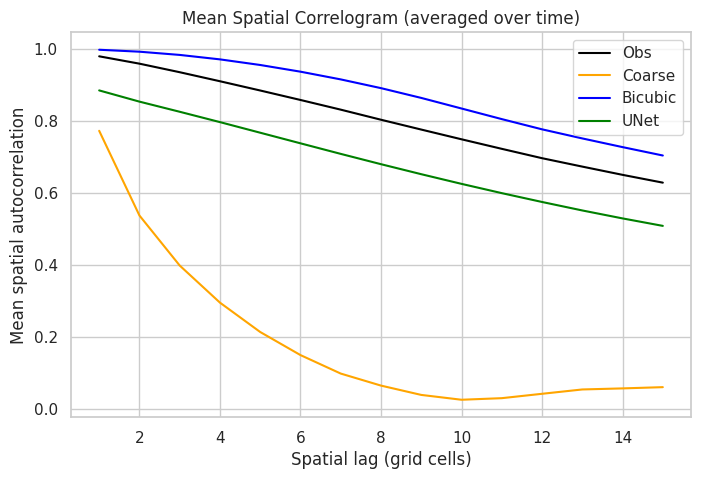

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def spatial_correlogram(field, max_lag=10):
    field = field - np.nanmean(field)
    corrs = []
    for lag in range(1, max_lag+1):
        shifted_x = np.roll(field, lag, axis=1)
        shifted_y = np.roll(field, lag, axis=0)
        shifted_x[:, :lag] = np.nan
        shifted_y[:lag, :] = np.nan
        valid_x = ~np.isnan(field) & ~np.isnan(shifted_x)
        valid_y = ~np.isnan(field) & ~np.isnan(shifted_y)
        corr_x = np.corrcoef(field[valid_x], shifted_x[valid_x])[0,1] if np.any(valid_x) else np.nan
        corr_y = np.corrcoef(field[valid_y], shifted_y[valid_y])[0,1] if np.any(valid_y) else np.nan
        corrs.append(np.nanmean([corr_x, corr_y]))
    return np.array(corrs)

max_lag = 15
n_time = obs_precip.shape[0]

corrs_obs = []
corrs_coarse = []
corrs_bicubic = []
corrs_unet = []

for t in range(n_time):
    corrs_obs.append(spatial_correlogram(obs_precip.isel(time=t).values, max_lag=max_lag))
    corrs_coarse.append(spatial_correlogram(coarse_precip.isel(time=t).values, max_lag=max_lag))
    corrs_bicubic.append(spatial_correlogram(bicubic_precip.isel(time=t).values, max_lag=max_lag))
    corrs_unet.append(spatial_correlogram(unet_precip.isel(time=t).values, max_lag=max_lag))

corrs_obs = np.nanmean(corrs_obs, axis=0)
corrs_coarse = np.nanmean(corrs_coarse, axis=0)
corrs_bicubic = np.nanmean(corrs_bicubic, axis=0)
corrs_unet = np.nanmean(corrs_unet, axis=0)

lags = np.arange(1, max_lag+1)
plt.figure(figsize=(8,5))
plt.plot(lags, corrs_obs, label='Obs', color='black')
plt.plot(lags, corrs_coarse, label='Coarse', color='orange')
plt.plot(lags, corrs_bicubic, label='Bicubic', color='blue')
plt.plot(lags, corrs_unet, label='UNet', color='green')
plt.xlabel('Spatial lag (grid cells)')
plt.ylabel('Mean spatial autocorrelation')
plt.title('Mean Spatial Correlogram (averaged over time)')
plt.legend()
plt.grid(True)
plt.show()